In [ ]:
import pandas as pd

In [ ]:
listings_df = pd.read_csv("Listings.csv", encoding='latin-1', low_memory=False)
reviews_df = pd.read_csv("Reviews.csv", encoding='latin-1', low_memory=False)

listings_df.dtypes

listing_id                       int64
name                            object
host_id                          int64
host_since                      object
host_location                   object
host_response_time              object
host_response_rate             float64
host_acceptance_rate           float64
host_is_superhost               object
host_total_listings_count      float64
host_has_profile_pic            object
host_identity_verified          object
neighbourhood                   object
district                        object
city                            object
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
accommodates                     int64
bedrooms                       float64
amenities                       object
price                            int64
minimum_nights                   int64
maximum_nights                   int64
review_scores_rating     

In [3]:
# Clean listing data
listings_df = listings_df[listings_df['city'] == "New York"]

listings_df = listings_df.drop_duplicates()

listings_df['host_since'] = pd.to_datetime(listings_df['host_since'], errors='coerce')

boolean_cols = ['instant_bookable', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified']
for col in boolean_cols:
    listings_df[col] = (listings_df[col].astype(str).str.strip().replace({'t': True, 'f': False}).astype(bool))

essential_cols = ['price', 'latitude', 'longitude']
listings_df = listings_df.dropna(subset=essential_cols)

review_cols = ['review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value']

listings_df = listings_df.dropna(subset=review_cols)

In [4]:
# Clean review data
reviews_df = reviews_df.drop_duplicates()

reviews_df['date'] = pd.to_datetime(reviews_df['date'], errors='coerce')

reviews_df = reviews_df.dropna(subset=['listing_id', 'date'])

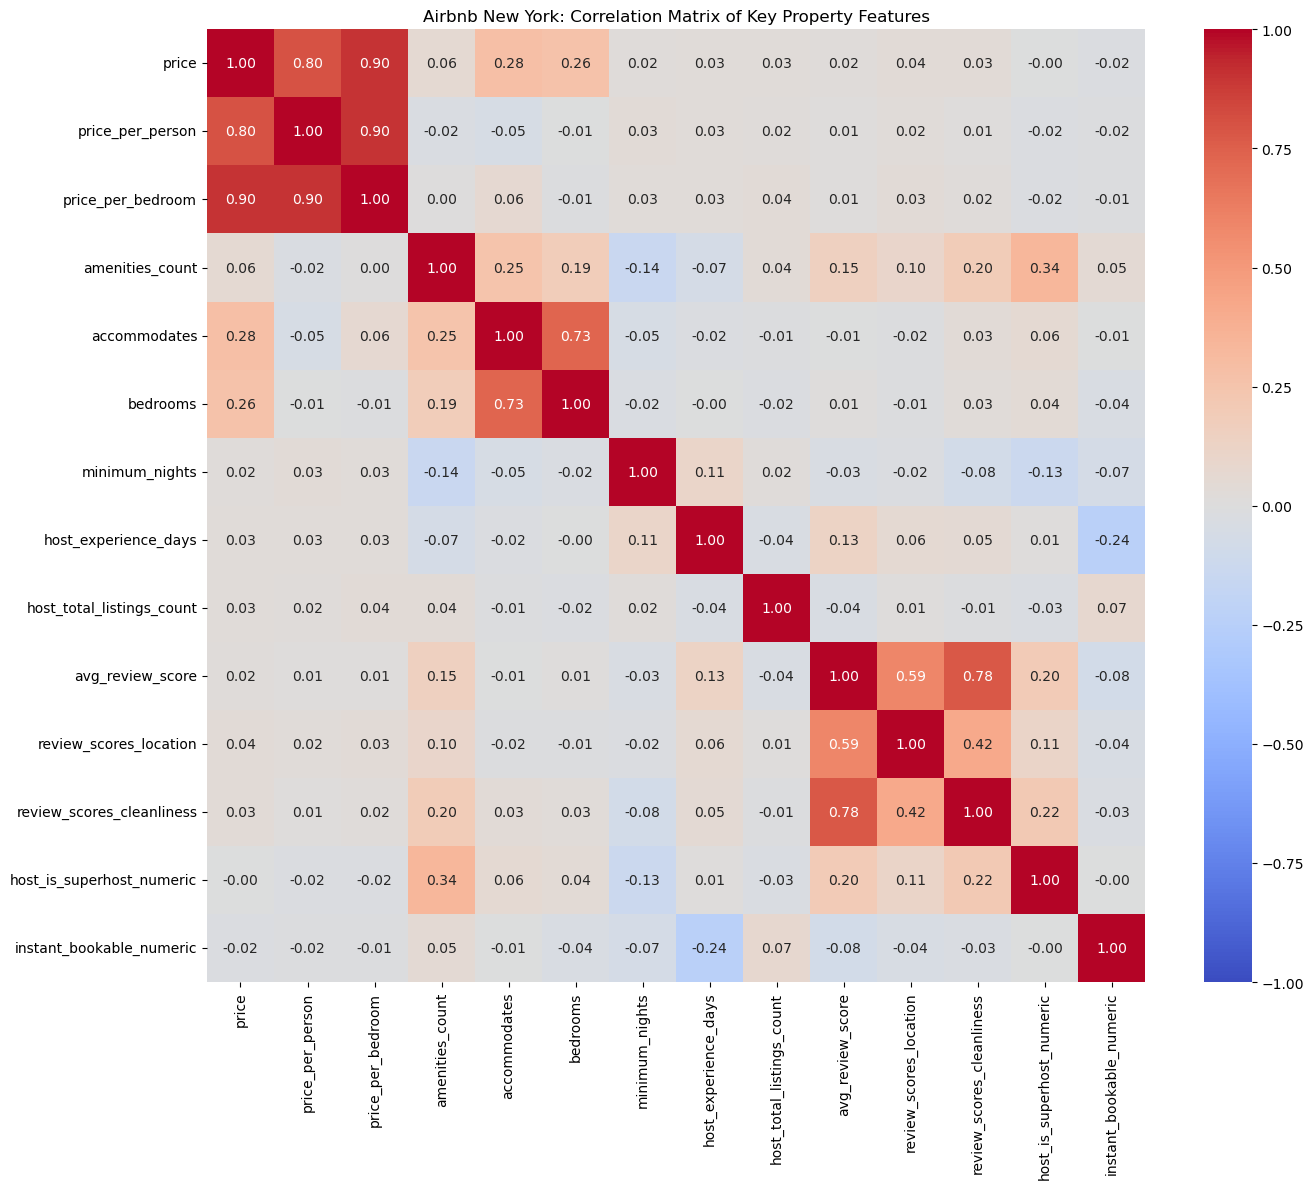

In [9]:
# Correlation Analysis for New York Airbnb Listings
# Note: Assuming the data cleaning steps have already been performed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime

# Create derived features for correlation analysis
# Convert boolean columns to numeric for correlation analysis
for col in boolean_cols:
    listings_df[f"{col}_numeric"] = listings_df[col].astype(int)

# Calculate price per person
listings_df['price_per_person'] = listings_df['price'] / listings_df['accommodates'].replace(0, 1)

# Calculate price per bedroom
listings_df['price_per_bedroom'] = listings_df['price'] / listings_df['bedrooms'].replace(0, 1)

# Extract amenities count
def count_amenities(amenities_str):
    try:
        if pd.isna(amenities_str):
            return 0
        # Handle the string format from the data
        amenities_str = str(amenities_str).replace("'", '"')  # Replace single quotes with double quotes
        amenities_list = json.loads(amenities_str)
        return len(amenities_list)
    except:
        return 0

listings_df['amenities_count'] = listings_df['amenities'].apply(count_amenities)

# Calculate host experience in days
listings_df['host_experience_days'] = (pd.Timestamp.now() - listings_df['host_since']).dt.days

# Calculate average review score
listings_df['avg_review_score'] = listings_df[review_cols].mean(axis=1)

# Select most relevant columns for correlation analysis
relevant_columns = [
    'price',
    'price_per_person',
    'price_per_bedroom',
    'amenities_count',
    'accommodates',
    'bedrooms',
    'minimum_nights',
    'host_experience_days',
    'host_total_listings_count',
    'avg_review_score',
    'review_scores_location',
    'review_scores_cleanliness',
    'host_is_superhost_numeric',
    'instant_bookable_numeric'
]

# Remove any remaining NaN values for correlation
correlation_df = listings_df[relevant_columns].dropna()

# Create correlation matrix
correlation_matrix = correlation_df.corr(numeric_only=True)

# Create a heatmap visualization for the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title("Airbnb New York: Correlation Matrix of Key Property Features")
plt.tight_layout()
plt.savefig('airbnb_nyc_correlation_heatmap.png')
plt.show()

In [14]:
# Fixed Neighborhood Comparison with Requested Features
# Note: This assumes listings_df has already been cleaned and processed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import ipywidgets as widgets

# Create a function to visualize neighborhood comparisons with fixed requested features
def compare_neighborhoods_fixed(selected_neighborhoods):
    # Define features as requested (fixed order, not sorted by variance)
    requested_features = [
        'price',                  # Average price
        'amenities_count',        # Average number of amenities
        'review_scores_location', # Average location score
        'price_per_person'        # Average price per person
    ]
    
    # Filter data to selected neighborhoods
    filtered_df = listings_df[listings_df['neighbourhood'].isin(selected_neighborhoods)]
    
    if filtered_df.empty:
        print("No data available for the selected neighborhoods.")
        return
    
    # Calculate neighborhood-level averages for each feature
    agg_dict = {feature: 'mean' for feature in requested_features}
    neighborhood_data = filtered_df.groupby('neighbourhood').agg(agg_dict).reset_index()
    
    # Setup figure and axes for 2x2 plot of requested features
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # More distinctive color palette
    colors = sns.color_palette("husl", len(selected_neighborhoods))
    
    # Fixed feature titles
    feature_titles = {
        'price': 'Average Price ($)',
        'amenities_count': 'Average Number of Amenities',
        'review_scores_location': 'Average Location Score (0-10)',
        'price_per_person': 'Average Price per Person ($)'
    }
    
    # Plot each feature in its fixed position
    for i, feature in enumerate(requested_features):
        # Create bar chart
        ax = axes[i]
        bars = ax.bar(neighborhood_data['neighbourhood'], 
                     neighborhood_data[feature],
                     color=colors)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            if feature in ['price', 'price_per_person']:
                label = f'${height:.0f}'
            elif feature == 'review_scores_location':
                label = f'{height:.1f}'
            else:
                label = f'{height:.1f}'
            
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   label, ha='center', va='bottom', fontweight='bold')
        
        # Set title and labels
        ax.set_title(feature_titles[feature], fontsize=14)
        ax.set_ylabel(feature_titles[feature])
        ax.set_xticklabels(neighborhood_data['neighbourhood'], rotation=45, ha='right')
        
        # Add grid for readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.suptitle("Neighborhood Comparison: Requested Features", 
                 fontsize=16, y=1.02)
    plt.show()

# Get list of neighborhoods with sufficient data
valid_neighborhoods = listings_df['neighbourhood'].value_counts()[listings_df['neighbourhood'].value_counts() >= 5].index.tolist()

# Create dropdown widget for neighborhood selection
neighborhood_dropdown = widgets.SelectMultiple(
    options=valid_neighborhoods,
    value=valid_neighborhoods[:3] if len(valid_neighborhoods) >= 3 else valid_neighborhoods,
    description='Neighborhoods:',
    disabled=False,
    layout=widgets.Layout(width='70%', height='200px')
)

# Create an output widget to display the comparison
output_widget = widgets.Output()

# Define the function to update the display when neighborhoods are selected
def on_neighborhood_selection_change(change):
    with output_widget:
        clear_output(wait=True)
        selected_neighborhoods = neighborhood_dropdown.value
        if len(selected_neighborhoods) >= 2:
            compare_neighborhoods_fixed(selected_neighborhoods)
        else:
            print("Please select at least 2 neighborhoods to compare.")

# Register the callback for when the neighborhood selection changes
neighborhood_dropdown.observe(on_neighborhood_selection_change, names='value')

# Create the interactive display
display(widgets.VBox([
    widgets.HTML(value="<h3>Airbnb Neighborhood Comparison - Requested Features</h3>"),
    widgets.HTML(value="<p>Select neighborhoods to compare (hold Ctrl/Cmd to select multiple):</p>"),
    neighborhood_dropdown,
    output_widget
]))

# Trigger initial display
on_neighborhood_selection_change(None)

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import folium

geospatial = geospatial[geospatial['ADM2_CODE'].str.startswith('USA-36')]

# location names in df
nyc_boroughs = ["Manhattan", "Bronx", "Brooklyn", "Queens", "Staten Island"]
listings_df = listings_df[listings_df['host_location'].str.contains('|'.join(nyc_boroughs), na=False, case=False)]

geospatial = geospatial.to_crs(epsg=4326) #CRS matches for spatial joins
listings_gdf = gpd.GeoDataFrame(listings_df, geometry=gpd.points_from_xy(listings_df.longitude, listings_df.latitude), crs="EPSG:4326")
interactive = gpd.sjoin(listings_gdf, geospatial, how='inner', predicate='intersects')


In [ ]:
interactive['log_review_score'] = np.log(interactive['review_scores_rating'] + 1)

m = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

interactive.explore(
        m=m,column='log_review_score',cmap='Reds',
        tooltip=['host_location', 'review_scores_rating'],popup=['host_location', 'review_scores_rating'],name='Log Review Scores',legend=True)

folium.GeoJson(geospatial, name='NYC Boundaries').add_to(m)
folium.TileLayer("CartoDB positron", show=True).add_to(m)
folium.LayerControl(collapsed=False).add_to(m)
m